<a href="https://colab.research.google.com/github/A01793509/Equipo_44/blob/main/Avance4_44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 **Avance 4. Modelos alternativos**: Explorar una gama diversa de técnicas y enfoques con el fin de identificar el de mejor desempeño en el conjunto de datos en cuestión. Encontrar la configuración óptima que maximiza el rendimiento del modelo en una tarea específica.

📑 **Asignatura**: Proyecto Integrador

📘 **Proyecto**: LunchForecast AI: Optimizador de reservas de almuerzos empresariales basado en inteligencia artificial.

📚 **Equipo**: 44

🧑 **Alumnos**:

Alberto José García Porras (Matrícula No. **A01793509**)

Erick Johan Najera Olivero (Matrícula No. **A01793506**)

Carlos Julio León Caicedo (Matrícula No. **A01793947**)

👩 **Profesores**:

Dra. Grettel Barceló Alonso

Dr. Luis Eduardo Falcón Morales

Dr. Guillermo Mota

📅 Mayo 26 del 2024

In [98]:
#Importamos las librerías que utilizaremos para la ejecución de la actividad
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import numpy as np
import warnings
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

👣**Obtener Datos**: Cargamos el archivo CSV con la información del consumo del casino desde enero del 2021 hasta marzo del 2024.

In [99]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
#dfCasinoConsumo = pd.read_csv("Consumo_test.csv",sep=";")
dfCasinoConsumoOriginal = dfCasinoConsumo
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1



---

☝**NOTA:** En este entregable iniciaremos aplicando los ajustes detectados en los entregables anteriores, referentes a la depuración de los datos y la ingeniería de características. Por lo tanto, la creación del baseline solicitando en esta entrega se identificará más adelante en la sección 2 del presente notebook.


---




---


👣 **SECCIÓN 1:** Limpieza y ajuste del conjunto de datos.



---



In [100]:
# Convierte la columna 'fecha del consumo' a tipo datetime si aún no lo está
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], format='%Y-%m-%d', errors='coerce')
#dfCasinoConsumo = dfCasinoConsumo.set_index('Fecha Consumo')
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1


In [101]:
#En el análisis, habíamos notado que existían valores de 'ALMUERZO' en minúsculas en el campo 'DETALLE'
#Por lo anterior, procederemos a pasar a mayúsculas el contenido de la columna antes de proceder con el borrado
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper()

#Filtramos el dataFrame para conservar solo las filas donde 'DETALLE' es igual a 'ALMUERZO' y lo guardamos en un
#nuevo dataframe para evitar SettingWithCopyWarning
dfCasinoAlmuerzos = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy()

In [102]:
#Eliminamos las columnas que no consideramos relevantes según hallazgos en la fase de exploración
dfCasinoConsumo=dfCasinoConsumo.drop(columns=['Consecutivo', 'Detalle','IdProducto', 'cod lector', 'Cod comedor', 'Identificacion persona', 'Invitado','Ing x planta','Nro empleados','Nivel'])
dfCasinoConsumo.head()

,Fecha Consumo,Tipo Empleado,Porcentaje apoyo
0,2021-01-03,Operativo,0
1,2021-01-03,Administrativo,90
2,2021-01-03,Operativo,0
3,2021-01-03,Operativo,90
4,2021-01-03,Administrativo,0


In [103]:
#Procedemos a realizar la codificación de las columnas categóricas
dfCasinoAlmuerzosCodificado = pd.get_dummies(dfCasinoConsumo, columns=['Tipo Empleado',  'Porcentaje apoyo'])
dfCasinoAlmuerzosCodificado.head()

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,False,False,True,True,False,False,False
1,2021-01-03,True,False,False,False,False,True,False
2,2021-01-03,False,False,True,True,False,False,False
3,2021-01-03,False,False,True,False,False,True,False
4,2021-01-03,True,False,False,True,False,False,False


In [104]:
#Para que el modelo que desarrollaremos más adelante funcione de una mejor manera,
#procederemos a convertir los valores booleanos a números.
#Recorremos todas las columnas y al identificar una booleana, la convertiremos en número.
for col in dfCasinoAlmuerzosCodificado.columns:
    if dfCasinoAlmuerzosCodificado[col].dtype == bool:
        dfCasinoAlmuerzosCodificado[col] = dfCasinoAlmuerzosCodificado[col].astype(int)

dfCasinoAlmuerzosCodificado.head(5)

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0


In [105]:
dfCasinoAlmuerzosCodificado

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
884610,2024-03-21,0,0,1,0,0,1,0
884611,2024-03-22,0,0,1,0,0,1,0
884612,2024-03-23,0,0,1,0,0,1,0
884613,2024-03-26,0,0,1,0,0,1,0


In [106]:
# Agrupar por 'Fecha' y realizar las agregaciones necesarias
dfAlmuerzoAgrupado = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').agg({
    'Tipo Empleado_Administrativo': 'sum',
    'Tipo Empleado_Aprendices': 'sum',
    'Tipo Empleado_Operativo': 'sum',
    'Porcentaje apoyo_0': 'sum',
    'Porcentaje apoyo_30': 'sum',
    'Porcentaje apoyo_90': 'sum',
    'Porcentaje apoyo_100': 'sum'
}).reset_index()

In [107]:
# Agregar una nueva columna con el conteo de registros por fecha
dfAlmuerzoAgrupado['Cantidad Almuerzos'] = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').size().values


In [108]:
# Convertir fechas a formato datetime
dfAlmuerzoAgrupado['Fecha Consumo'] = pd.to_datetime(dfAlmuerzoAgrupado['Fecha Consumo'])

# Asegúrate de que el DataFrame esté ordenado por fecha
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.sort_values('Fecha Consumo')

# Configurar la fecha como el índice
dfAlmuerzoAgrupado.set_index('Fecha Consumo', inplace=True)
dfAlmuerzoAgrupado.index

DatetimeIndex(['2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10',
               '2021-01-11', '2021-01-12',
               ...
               '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
               '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-03-30', '2024-03-31'],
              dtype='datetime64[ns]', name='Fecha Consumo', length=1181, freq=None)

In [109]:
fecha_inicio = dfAlmuerzoAgrupado.index.min()
fecha_fin = dfAlmuerzoAgrupado.index.max()
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
# Reindexar el DataFrame
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.reindex(rango_fechas)

dfAlmuerzoAgrupado.fillna(0,inplace=True)

# Seleccionar el valor de una columna específica en una fecha específica usando at
# Especifica la fecha que deseas filtrar
fecha_especifica = '2022-01-01'

# Convertir la fecha específica a tipo datetime
fecha_especifica = pd.to_datetime(fecha_especifica)

# Filtrar el DataFrame para la fecha específica
try:
    registro_filtrado = dfAlmuerzoAgrupado.loc[fecha_especifica]
    print(f"Registro para la fecha {fecha_especifica.date()}:\n{registro_filtrado}")
except KeyError:
    print(f"No hay registros para la fecha {fecha_especifica.date()}")

dfAlmuerzoAgrupado.info()


Registro para la fecha 2022-01-01:
Tipo Empleado_Administrativo    0.0
Tipo Empleado_Aprendices        0.0
Tipo Empleado_Operativo         0.0
Porcentaje apoyo_0              0.0
Porcentaje apoyo_30             0.0
Porcentaje apoyo_90             0.0
Porcentaje apoyo_100            0.0
Cantidad Almuerzos              0.0
Name: 2022-01-01 00:00:00, dtype: float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1184 entries, 2021-01-03 to 2024-03-31
Freq: D
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tipo Empleado_Administrativo  1184 non-null   float64
 1   Tipo Empleado_Aprendices      1184 non-null   float64
 2   Tipo Empleado_Operativo       1184 non-null   float64
 3   Porcentaje apoyo_0            1184 non-null   float64
 4   Porcentaje apoyo_30           1184 non-null   float64
 5   Porcentaje apoyo_90           1184 non-null   float64
 6   Porcentaje apoyo_100      

In [110]:
# Variable endógena (consumo)
dfendog = dfAlmuerzoAgrupado['Cantidad Almuerzos']

# Variables exógenas
dfexog = dfAlmuerzoAgrupado[['Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Tipo Empleado_Administrativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]

In [111]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(dfAlmuerzoAgrupado) * 0.7)
train_endog1 = dfendog[:train_size]
test_endog1 = dfendog[train_size:]

train_exog = dfexog[:train_size]
test_exog = dfexog[train_size:]

In [112]:
train_endog = train_endog1.to_frame()
test_endog = test_endog1.to_frame()




---


# 🔖 **Rúbrica - Criterio: Comparativa**


---



🦾 **Modelo 1: SARIMAX**


---



In [113]:
# Definir los parámetros SARIMAX
p, d, q = 1, 2, 1 # Parámetros ARIMA
P, D, Q, s = 1, 1, 1, 12 # Parámetros estacionales (ejemplo con estacionalidad anual)

# Ajustar el modelo
model = sm.tsa.SARIMAX(train_endog, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Resumen del modelo
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                 Cantidad Almuerzos   No. Observations:                  828
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                   4.920
Date:                            Sun, 26 May 2024   AIC                             14.160
Time:                                    00:37:06   BIC                             70.584
Sample:                                01-03-2021   HQIC                            35.818
                                     - 04-10-2023                                         
Covariance Type:                              opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Tipo Empleado_Aprendices         0.5714   6.08e-11    9.4e+09      0.000      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


In [114]:
start_date = test_endog.index[0]  # La primera fecha del conjunto de prueba
end_date =  test_endog.index[-1]

#start_index = len(train_endog)  # Índice de inicio para predicción en el conjunto de prueba
#end_index = start_index + len(test_endog) - 1  # Índice de fin para predicción en el conjunto de prueba




In [115]:
 # Predicciones
pred = results.get_prediction(start=start_date, end=end_date, exog=test_exog)
#pred = results.get_prediction(start=start_index, end=end_index, exog=test_exog)
#pred = results.get_prediction(start='2023-08-07', end='2024-03-31', exog=test_exog)
pred_mean = pred.predicted_mean

  # Intervalos de confianza
pred_ci = pred.conf_int()


In [116]:
print(pred_mean)

comparison_df = pd.concat([test_endog, pred_mean], axis=1)
comparison_df.columns = ['Real', 'Predicciones']
print(comparison_df)

2023-04-11     716.137280
2023-04-12     744.198175
2023-04-13     763.255911
2023-04-14     723.314906
2023-04-15     624.374185
                 ...     
2024-03-27    1216.317194
2024-03-28     715.412168
2024-03-29     655.507419
2024-03-30     636.602944
2024-03-31     444.698741
Freq: D, Name: predicted_mean, Length: 356, dtype: float64
              Real  Predicciones
2023-04-11   700.0    716.137280
2023-04-12   728.0    744.198175
2023-04-13   747.0    763.255911
2023-04-14   707.0    723.314906
2023-04-15   608.0    624.374185
...            ...           ...
2024-03-27  1173.0   1216.317194
2024-03-28   672.0    715.412168
2024-03-29   612.0    655.507419
2024-03-30   593.0    636.602944
2024-03-31   401.0    444.698741

[356 rows x 2 columns]


In [117]:
from sklearn.metrics import mean_squared_error

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test_endog, pred_mean))
print('RMSE: ', rmse)

RMSE:  29.931063054187177


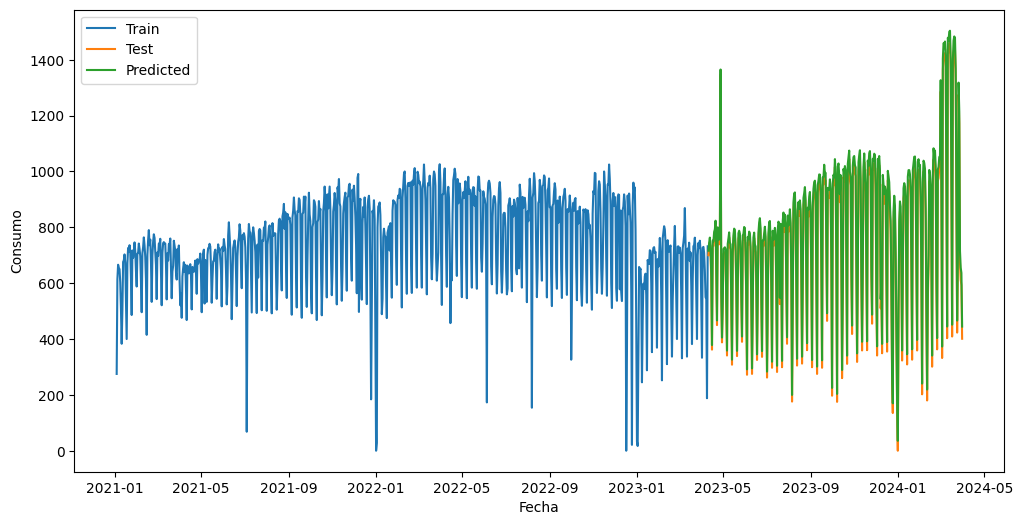

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_endog, label='Train')
plt.plot(test_endog, label='Test')
plt.plot(pred_mean, label='Predicted')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [119]:
#Calculamos MAE y RMSE
MAE = mean_absolute_error(test_endog, pred_mean)
RMSE = np.sqrt(mean_squared_error(test_endog, pred_mean))

#Calculamos MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE = mean_absolute_percentage_error(comparison_df['Real'], comparison_df['Predicciones'])

print(f'*********************************************')
print(f'Métricas para el modelo SARIMAX (statsmodels)')
print(f'*********************************************')
print(f'MAE: {MAE}')
print(f'RMSE: {RMSE}')
print(f'MAPE: {MAPE}')

*********************************************
Métricas para el modelo SARIMAX (statsmodels)
*********************************************
MAE: 28.84379472073682
RMSE: 29.931063054187177
MAPE: inf


<ipython-input-119-514f9f8a857e>:8: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [120]:
# Calcular MBE
mbe = (pred_mean - test_endog['Cantidad Almuerzos']).mean()

# Mostrar los resultados
print(f"Mean Bias Error (MBE): {mbe}")

Mean Bias Error (MBE): 28.84379472073682


In [121]:
weights = np.ones_like(test_endog['Cantidad Almuerzos'])  # Por ejemplo, usar pesos iguales para simplificar
# Puedes modificar `weights` para asignar diferentes pesos a diferentes fechas

# Calcular WMAE
absolute_errors = np.abs(pred_mean - test_endog['Cantidad Almuerzos'])
wmae = np.sum(weights * absolute_errors) / np.sum(weights)

# Mostrar los resultados
print(f"Weighted Mean Absolute Error (WMAE): {wmae}")


Weighted Mean Absolute Error (WMAE): 28.84379472073682


⏰**Hasta aqui el modelo 1 sarimax con endogenas**



---


🦾 **Modelo 2: ARIMA**


---



In [122]:
from statsmodels.tsa.arima.model import ARIMA

# Datos de ejemplo (suponiendo que 'df' es tu DataFrame y 'fecha' es tu índice)
# df = pd.read_csv('ruta/a/tu/dataset.csv', parse_dates=['fecha'], index_col='fecha')

# Definir el modelo ARIMA
modelo_ARIMA = ARIMA(test_endog['Cantidad Almuerzos'], order=(p, d, q))

# Ajustar el modelo
results = modelo_ARIMA.fit()

# Hacer predicciones
predictions = results.get_forecast(steps=10)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

print(predicted_mean)
print(confidence_intervals)


2024-04-01    414.671230
2024-04-02    412.915638
2024-04-03    412.317168
2024-04-04    411.631907
2024-04-05    410.953155
2024-04-06    410.273915
2024-04-07    409.594711
2024-04-08    408.915505
2024-04-09    408.236299
2024-04-10    407.557093
Freq: D, Name: predicted_mean, dtype: float64
            lower Cantidad Almuerzos  upper Cantidad Almuerzos
2024-04-01               -127.018133                956.360592
2024-04-02               -326.010682               1151.841958
2024-04-03               -483.834889               1308.469226
2024-04-04               -618.591469               1441.855282
2024-04-05               -738.427448               1560.333757
2024-04-06               -847.587968               1668.135797
2024-04-07               -948.633490               1767.822912
2024-04-08              -1043.247591               1861.078601
2024-04-09              -1132.606962               1949.079560
2024-04-10              -1217.572053               2032.686239


In [123]:
# Calcular los errores absolutos entre las predicciones y los valores reales
mae = mean_absolute_error(test_endog, pred_mean)
print(mae)

28.84379472073682


In [124]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Calcular los errores absolutos entre las predicciones y los valores reales
errors = abs(test_endog - pred_mean)

# Normalizar los pesos para que sumen 1
weights = weights / np.sum(weights)

# Verificar longitudes de datos
assert len(test_endog) == len(pred_mean) == len(weights), "Las longitudes de los datos no coinciden"

# Calcular el WMAE
wmae = np.sum(errors * weights) / np.sum(weights)

print("WMAE:", wmae)


ValueError: Unable to coerce to Series, length must be 357: given 356

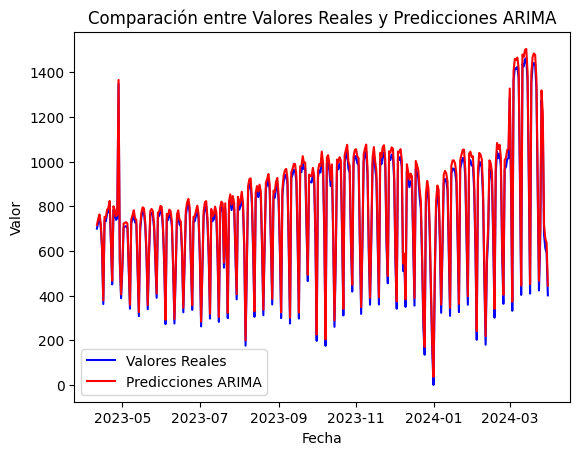

In [125]:
# Graficar los valores reales
plt.plot(test_endog, label='Valores Reales', color='blue')

# Graficar las predicciones
plt.plot(pred_mean, label='Predicciones ARIMA', color='red')

# Agregar etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación entre Valores Reales y Predicciones ARIMA')
plt.legend()

# Mostrar la gráfica
plt.show()


⏰**Hasta aqui el modelo 2 ARIMA con endogenas**



---


🦾 **Modelo 3: REGRESIÓN LINEAL**


---


In [128]:
from sklearn.linear_model import LinearRegression

# Crear una instancia del modelo de regresión lineal
Modelo_REGRESION = LinearRegression()

# Entrenar el modelo utilizando los datos de entrenamiento
Modelo_REGRESION.fit(train_exog, train_endog)


LinearRegression()

In [130]:
# Hacer predicciones en el conjunto de prueba
predicciones = Modelo_REGRESION.predict(test_exog)


In [131]:
# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(test_endog, predicciones)

# Calcular el coeficiente de determinación (R²)
r2 = r2_score(test_endog, predicciones)

print("Error Cuadrático Medio (MSE):", mse)
print("Coeficiente de Determinación (R²):", r2)

Error Cuadrático Medio (MSE): 4.407920739185151e-26
Coeficiente de Determinación (R²): 1.0


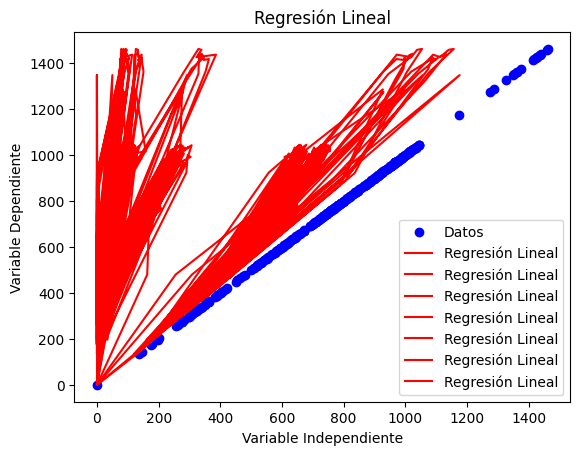

In [134]:
# Graficar los datos de dispersión (scatter plot)
plt.scatter(test_endog, predicciones, color='blue', label='Datos')

# Graficar la regresión lineal
plt.plot(test_exog, Modelo_REGRESION.predict(test_exog), color='red', label='Regresión Lineal')

# Agregar etiquetas y leyenda
plt.xlabel('Variable Independiente')
plt.ylabel('Variable Dependiente')
plt.title('Regresión Lineal')
plt.legend()

# Mostrar la gráfica
plt.show()


⏰**Hasta aqui el modelo 3 REGRESIÓN LINEAL**



---


🦾 **Modelo 4: ÁRBOL DE REGRESIÓN**


---


In [149]:
#import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error

# Concatenar los DataFrames a lo largo de las columnas
df_concatenado = pd.concat([train_exog, train_endog], axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df_concatenado.drop(columns=["Cantidad Almuerzos"])  # Variables exógenas
y = df_concatenado["Cantidad Almuerzos"]  # Variable endógena

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

Error Cuadrático Medio (MSE): 293.0542168674699


In [ ]:
# Crear una instancia del modelo de árbol de regresión
modelo_arbol_regresion = DecisionTreeRegressor()

# Entrenar el modelo utilizando los datos de entrenamiento
modelo_arbol_regresion.fit(X_entrenamiento, y_entrenamiento)

In [150]:
# Hacer predicciones en el conjunto de prueba
predicciones = modelo_arbol_regresion.predict(X_prueba)

# Mostrar las predicciones
print("Predicciones:", predicciones)

Predicciones: [ 648.  931.  857.  896.  496.  914.  754.  706.  852.  652.  701.  712.
  620.  729.  703.  779.  854.  475.  702.  801.  929.  533.  503.  884.
  852.  979.  674.  731.  492.  610.  779.  188.  646.  897.  723.  883.
  931.  724.  739.  747.  854.  545.  663.  865.  716.  739.  713.  519.
  865.  812.  907.  957. 1000.  845.  836.  562.  653.  310.  906.  931.
  557.  544.  936.  666.  864.  835.  691.  587.  969.  953.   28.  496.
  400.  645.  643.  400.  738.  612.  676.  736.  729.  942.  648.  772.
  833.  701.  729.  678.  563.  662.  918.  658.  795.  587.  948.  664.
  652.  496.  872.  891.  734.  679.  569.  666.  580.  707.  331.  875.
  664.  727.  562.  892.  674.  648.  690.  732.  562.  865. 1011.  679.
  637.  676.  584.  666.  866.  601.  891.  814.  886.  656.  648.  648.
  703.  876.  980. 1011. 1000.  737.  584.  650.  918.  980.  883.  643.
  865.  942.  935. 1000.  918.  930.  415.  805.  584.  643.  875.  907.
  679.  673.  703.  623.  905.  936. 

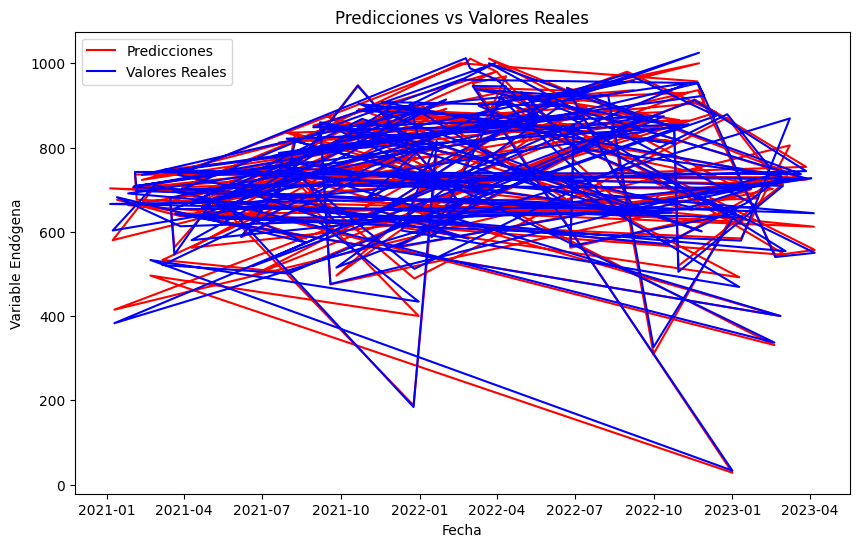

In [151]:
import matplotlib.pyplot as plt

# Graficar los resultados
plt.figure(figsize=(10, 6))

# Graficar las predicciones
plt.plot(y_prueba.index, predicciones, label='Predicciones', color='red')

# Graficar los valores reales
plt.plot(y_prueba.index, y_prueba, label='Valores Reales', color='blue')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Variable Endógena')
plt.title('Predicciones vs Valores Reales')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()


In [152]:
# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_prueba, predicciones)
print("Error Cuadrático Medio (MSE):", mse)

Error Cuadrático Medio (MSE): 293.0542168674699


⏰**Hasta aqui el modelo 4 ÁRBOL DE REGRESIÓN**


---


👣 **SECCIÓN 2:** Baseline.



---

In [ ]:
#Establecemos un indice para nuestro conjunto de datos, esto nos servirá para generar la serie de tiempo
#con la que realizaremos las predicciones más adelante
dfBaseLine = dfCasinoAlmuerzosCodificado[['Fecha Consumo', 'Detalle']]
dfBaseLine['Fecha Consumo'] = pd.to_datetime(dfBaseLine['Fecha Consumo'], format='%Y-%m-%d')
dfBaseLine = dfBaseLine.set_index('Fecha Consumo')
#Visualizamos los primeros 5 registros del dataframe
dfBaseLine.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-350-63abee21df73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfBaseLine['Fecha Consumo'] = pd.to_datetime(dfBaseLine['Fecha Consumo'], format='%Y-%m-%d')


,Detalle
Fecha Consumo,
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO


In [ ]:
#Ejecutamos el split de los datos para generar los datasets de entrenamiento y pruebas.
dfCasinoAlmuerzosCodificado = dfBaseLine
#Definimos rangos de fechas para el conjunto de entrenamiento con el fin de garantizar
#un orden cronológico en los datos a utilizar.
#Entrenamiento: desde 2021-01-03 hasta 2023-09-30
#Pruebas: desde 2023-09-30 hasta 2024-03-31
Limite_Train = '2023-09-30'
#Imprimimos los límites para validar la correcta segmentación de los datos.
print(
    f"Fechas conjunto entrenamiento: {dfCasinoAlmuerzosCodificado.index.min()} --- {dfCasinoAlmuerzosCodificado.loc[:Limite_Train].index.max()}  "
    f"(n={len(dfCasinoAlmuerzosCodificado.loc[:Limite_Train])})"
)
print(
    f"Fechas conjunto pruebas: {dfCasinoAlmuerzosCodificado.loc[Limite_Train:].index.min()} --- {dfCasinoAlmuerzosCodificado.loc[:].index.max()}  "
    f"(n={len(dfCasinoAlmuerzosCodificado.loc[Limite_Train:])})"
)
dfBaseLineTrain = dfCasinoAlmuerzosCodificado.loc[:Limite_Train]
dfBaseLineTest  = dfCasinoAlmuerzosCodificado.loc[Limite_Train:]

Fechas conjunto entrenamiento: 2021-01-03 00:00:00 --- 2023-09-30 00:00:00  (n=431617)
Fechas conjunto pruebas: 2023-09-30 00:00:00 --- 2024-03-31 00:00:00  (n=92606)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Con el fin de facilitar las predicciones del modelo, agrupamos la cantidad de almuerzos por día.
#El objetivo es que podamos crear nuestro baseline con los datos de la variable a predecir agrupados.
grouped_train = dfBaseLineTrain.groupby('Fecha Consumo')['Detalle'].count()
grouped_test = dfBaseLineTest.groupby('Fecha Consumo')['Detalle'].count()
#Imprimimos los primeros 5 registros del conjunto de entrenamiento, para validar que quedaron agrupados por día.
grouped_train.head(5)

Fecha Consumo
2021-01-03    178
2021-01-04    370
2021-01-05    386
2021-01-06    391
2021-01-07    377
Name: Detalle, dtype: int64

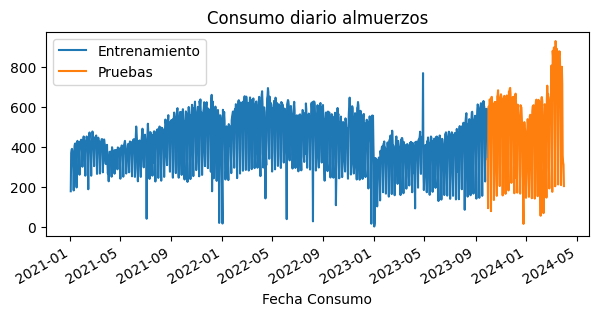

In [ ]:
#Graficamos la distribución de los almuerzos diferenciando los datos del conjunto de entrenamiento y pruebas.
#Lo anterior respetando el orden cronológico del conjunto de datos.
fig, ax=plt.subplots(figsize=(7, 3))
grouped_train.plot(ax=ax, label='Entrenamiento')
grouped_test.plot(ax=ax, label='Pruebas')
ax.set_title('Consumo diario almuerzos')
ax.legend();

---

📚 Acorde a la investigación realizada, concluímos que para dar solución a la necesidad planteada utilizando series de tiempo, el modelo recomendado como baseline será **SARIMAX**. Sin embargo, este modelo es susceptible a la estacionariedad de los datos en el conjunto, por ende, procederemos a validar esta caracteristica utilizando las siguientes técnicas:
* **Prueba de Dickey-Fuller aumentada (ADF)**: analiza la serie de tiempo y genera un valor de P que indica la estacionariedad de la serie, si el valor de P es inferior a 0,05 (umbral reconocido) la serie se considerará estacionaria, de lo contrario sugerirá que no es estacionaria.
* **Prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**: funciona similar a la técnica ADF, sin embargo, el valor de P se basará en la búsqueda de tendencias para determinar el nivel de estacionariedad en el conjunto.


---

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


------------------------------------------
Prueba de estacionariedad datos originales
------------------------------------------
Resultado ADF: -3.4731656202966716, p-value: 0.008703602748095377
Resultado KPSS: 1.1755548738439585, p-value: 0.01
-------------------------------------------------------------

Prueba de estacionariedad para serie diferenciada (orden=1)
-------------------------------------------------------------
Resultado ADF: -10.316328232064834, p-value: 3.0904357865978174e-18
Resultado KPSS: 0.07477478068387071, p-value: 0.1


<Axes: title={'center': 'Series diferenciadas orden 1'}, xlabel='Fecha Consumo'>

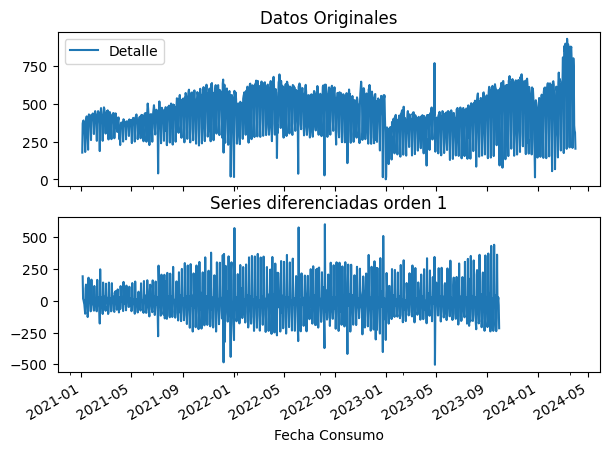

In [ ]:
#Ejecutamos los test para determinar el nivel de estacionariedad en nuestro conjunto
warnings.filterwarnings("ignore")

#Calculamos la diferencia de elementos en las series.
sDiferencia1Datos = grouped_train.diff().dropna()
sDiferencia2Datos = sDiferencia1Datos.diff().dropna()

print('------------------------------------------')
print('Prueba de estacionariedad datos originales')
print('------------------------------------------')
resultado_ADF = adfuller(grouped)
resultado_KPSS = kpss(grouped)
print(f'Resultado ADF: {resultado_ADF[0]}, p-value: {resultado_ADF[1]}')
print(f'Resultado KPSS: {resultado_KPSS[0]}, p-value: {resultado_KPSS[1]}')

print('-------------------------------------------------------------')
print('\nPrueba de estacionariedad para serie diferenciada (orden=1)')
print('-------------------------------------------------------------')
resultado_ADF = adfuller(sDiferencia1Datos)
resultado_KPSS = kpss(grouped.diff().dropna())
print(f'Resultado ADF: {resultado_ADF[0]}, p-value: {resultado_ADF[1]}')
print(f'Resultado KPSS: {resultado_KPSS[0]}, p-value: {resultado_KPSS[1]}')

#Graficamos el resultado obtenido
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
grouped.plot(ax=axs[0], title='Datos Originales')
sDiferencia1Datos.plot(ax=axs[1], title='Series diferenciadas orden 1')


---

✍**Análisis:** Al realizar la primera prueba de estacionariedad, observamos que el valor de P para ADF es menor a 0,05 (0,008), por lo cual, se entendería que el conjunto de datos posee estacionariedad. Sin embargo, realizamos una prueba adicional para una serie diferenciada de orden 1 con el fin de validar la diferencia en los resultados. Teniendo en cuenta lo anterior, concluímos que podemos trabajar nuestro baseline con los datos originales.

---

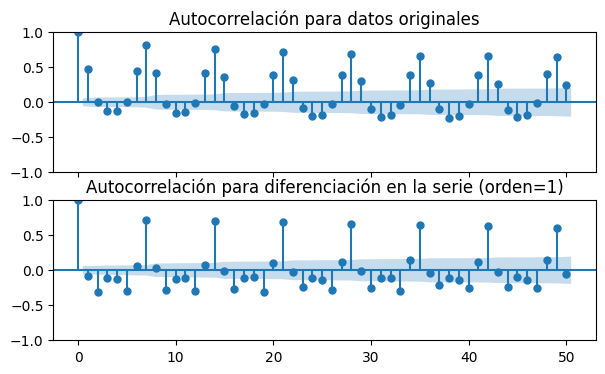

In [ ]:
#Generamos el gráfico de autocorrelación para las series original y diferenciada de orden 1
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(grouped, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación para datos originales')
plot_acf(sDiferencia1Datos, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación para diferenciación en la serie (orden=1)');

---

✍**Análisis:** Observamos picos significativos mostrando autocorrelaciones relevantes en los puntos 1, 12, 24, 36 y 48 de la gráfica, lo cual nos sugiere presencia de patrones estacionarios en la serie de datos. Asimismo, observamos que la mayoría de los valores de autocorrelación se encuentran dentro de la zona de confianza (sombreada en azul cercanos a cero), lo cual nos confirma que la serie original presenta altos indicios de estacionariedad  

---



---


#### ☝  **¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?**
Basados en el análisis realizado hasta ahora referente a la estacionariedad en el conjunto de datos para nuestra serie de tiempo, concluímos que podemos utilizar el algoritmo del modelo **SARIMAX** para generar nuestro baseline y predecir nuestra variable objetivo (cantidad de almuerzos por día).


---




---


# 🔖 **Rúbrica - Criterio: Características importantes**


---

In [ ]:
#Comenzamos a implementar el modelo SARIMAX con el método más convencional para iniciar nuestro baseline,
#utilizando "statsmodels", ya que nos permite obtener datos adicionales como residuos o parámetros aprendidos,
#claves para la generación de futuras predicciones.
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
ModeloCasino = SARIMAX(endog = grouped_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
ModeloCasino_Resultante = ModeloCasino.fit(disp=0)
warnings.filterwarnings("default")
ModeloCasino_Resultante.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Detalle   No. Observations:                  999
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6128.223
Date:                            Sun, 19 May 2024   AIC                          12266.447
Time:                                    19:49:50   BIC                          12290.915
Sample:                                         0   HQIC                         12275.753
                                            - 999                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5254      0.024     21.559      0.000       0.478       0.573
ma.L1         -0.9998      0.025    -39.353      0.000      -1.050      -0.950
ar.S.L12      -0.2050      0.035     -5.929      0.000      -0.273      -0.137
ma.S.L12      -0.9998      3.386     -0.295      0.768      -7.636       5.636
sigma2      1.366e+04   4.59e+04      0.297      0.766   -7.64e+04    1.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.19   Jarque-Bera (JB):                25.20
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Una vez entrenado el modelo SARIMAX con los datos de entrenamiento, procedemos a realizar las predicciones
#con el conjunto de datos de prueba.
Prediccion_Almuerzos_Statsmodels = ModeloCasino_Resultante.get_forecast(steps=len(grouped_test)).predicted_mean
Prediccion_Almuerzos_Statsmodels.name = 'Prediccion_Almuerzos_Statsmodels'

#Creamos un dataframe con las fechas del conjunto de pruebas y las predicciones realizadas
dfPrediccion_Almuerzos_Statsmodels = pd.DataFrame({'Fecha Consumo': grouped_test.index, 'Pred. Consumos': Prediccion_Almuerzos_Statsmodels.values})
dfPrediccion_Almuerzos_Statsmodels.set_index('Fecha Consumo', inplace=True)

#Visualizamos los primeros 10 registros del dataframe con las predicciones
dfPrediccion_Almuerzos_Statsmodels.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Pred. Consumos
Fecha Consumo,
2023-09-30,368.060522
2023-10-01,370.159771
2023-10-02,390.645452
2023-10-03,376.589000
2023-10-04,430.517659
2023-10-05,462.342826
2023-10-06,385.871180
2023-10-07,397.747138
2023-10-08,390.839996


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


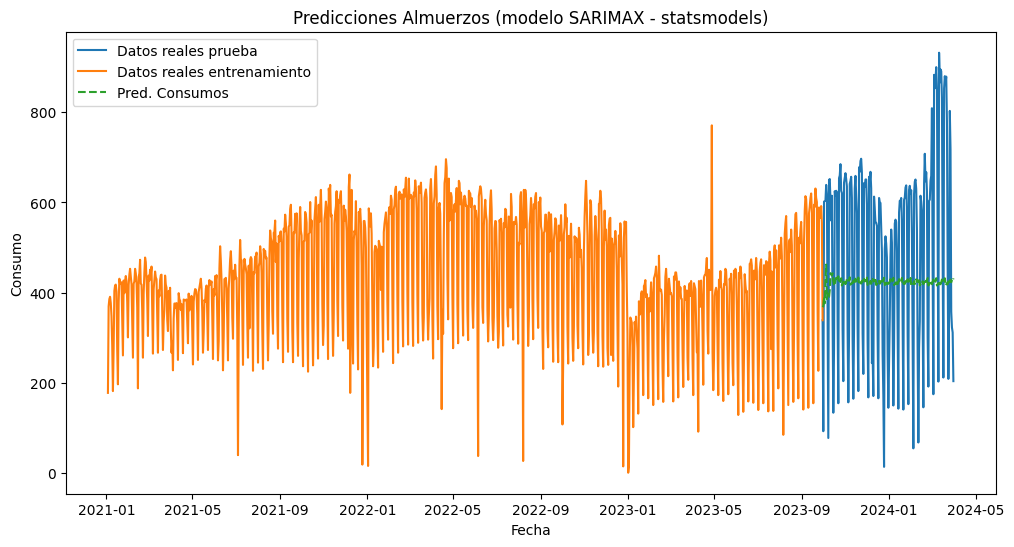

In [ ]:
#Visualizamos las predicciones graficamente, incluyendo la tendencia en los datos para los conjuntos de
#entrenamiento y pruebas, mostrando en color verde las predicciones realizadas por el modelo.
plt.figure(figsize=(12, 6))
plt.plot(grouped_test, label='Datos reales prueba')
plt.plot(grouped_train, label='Datos reales entrenamiento')
plt.plot(dfPrediccion_Almuerzos_Statsmodels['Pred. Consumos'], label='Pred. Consumos', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Predicciones Almuerzos (modelo SARIMAX - statsmodels)')
plt.legend()
plt.show()



---


#### ☝  **¿Se puede determinar la importancia de las características para el modelo generado?**
Las predicciones obtenidas (línea verde) muestran una suavización en la tendencia comparándola con los datos históricos, lo cual nos indica que el modelo intentó suavizar las variaciones y normalizar un nivel de consumo promedio para los almuerzos. Por lo tanto, la variabilidad observada en nuestros datos históricos no la vemos reflejada en las predicciones, probablemente por un ajuste insuficiente en los parámetros estacionales enviados al entrenamiento del modelo SARIMAX. Asimismo, concluímos que existen otras variables que al incluirlas en el entrenamiento, nos ayudarían a mejorar la precisión del modelo, tales como el porcentaje de apoyo, el nivel del empleado y el tipo de empleado. Por lo tanto, consideramos que sí es importante incluir las caracteristicas adicionales identificadas para que el modelo generado funcione con una precisión mayor.

---





---


# 🔖 **Rúbrica - Criterio: Sub / sobreajuste**


---

---

📚 Procederemos a validar si el modelo se encuentra sub/sobre ajustando los datos del conjunto de entrenamiento.


---

In [ ]:
#Vamos a validar si el modelo se encuentra sub o sobre ajustado. Para ello, realizamos una comparación
#de las predicciones con los datos reales.
comparison_df = pd.concat([grouped_test, dfPrediccion_Almuerzos_Statsmodels], axis=1)
comparison_df.columns = ['Real', 'Predicciones']
print(comparison_df)

               Real  Predicciones
Fecha Consumo                    
2023-09-30      339    368.060522
2023-10-01       93    370.159771
2023-10-02      602    390.645452
2023-10-03      603    376.589000
2023-10-04      604    430.517659
...             ...           ...
2024-03-27      718    429.095893
2024-03-28      358    423.429892
2024-03-29      323    426.177525
2024-03-30      312    424.115222
2024-03-31      204    431.878207

[183 rows x 2 columns]


---

✍**Análisis:** A primera vista observamos una diferencia significativa en las predicciones generadas, que oscilan entre 200 y 300 almuerzos en la mayoría de los casos. Para obtener un mejor panorama, procederemos a calculas las métricas MAE, RMSE y MAPE, que nos permitirán identificar la efectividad del modelo.

---

In [ ]:
#Calculamos MAE y RMSE
MAE = mean_absolute_error(grouped_test, Prediccion_Almuerzos_Statsmodels)
RMSE = np.sqrt(mean_squared_error(grouped_test, Prediccion_Almuerzos_Statsmodels))

#Calculamos MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE = mean_absolute_percentage_error(comparison_df['Real'], comparison_df['Predicciones'])

print(f'*********************************************')
print(f'Métricas para el modelo SARIMAX (statsmodels)')
print(f'*********************************************')
print(f'MAE: {MAE}')
print(f'RMSE: {RMSE}')
print(f'MAPE: {MAPE}')

*********************************************
Métricas para el modelo SARIMAX (statsmodels)
*********************************************
MAE: 207.0212921677632
RMSE: 230.24305659958972
MAPE: 74.17890991473121


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---

✍**Análisis:** Los valores obtenidos en las métricas para las predicciones sobre el conjunto de pruebas nos confirman que la diferencia entre los valores reales y las predicciones oscilan entre los 200 y 300 almuerzos. Destacándose el RMSE con 230 unidades por encima del MAE con 207. Asimismo, observamos que el error porcentual absoluto medio (MAPE) nos muestra un 74.18% de diferencias entre las predicciones del modelo y los valores reales.

---

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


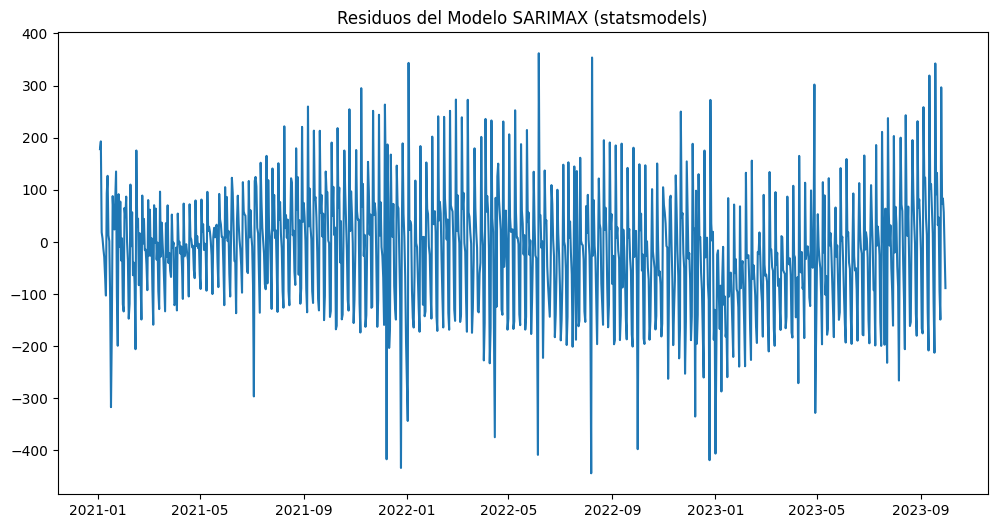

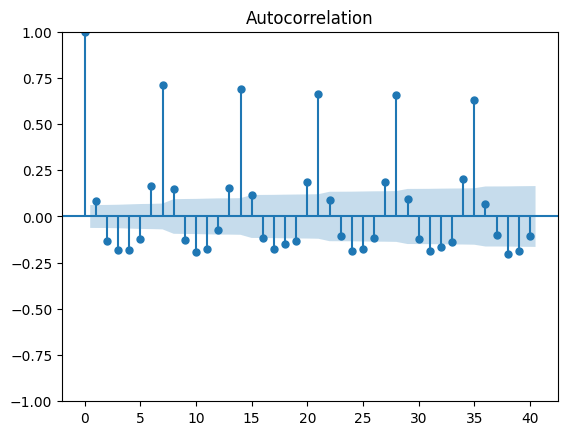

In [ ]:
#Procedemos ahora a graficar los residuos del modelo para verificar si se están capturando
#correctamente la variabilidad en los datos.
Residuos = ModeloCasino_Resultante.resid
plt.figure(figsize=(12, 6))
plt.plot(Residuos)
plt.title('Residuos del Modelo SARIMAX (statsmodels)')
plt.show()

#Graficamos la autocorrelación de los residuos obtenidos
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Residuos, lags=40)
plt.show()


---

✍**Análisis:** Revisando la gráfica inicial, observamos que la dispersión de los residuos en el modelo varían de forma sistemática a lo largo de los periodos, por lo cual, concluímos que no está asimilando la variabilidad de los datos en el conjunto. Debemos revisar enfoques para gestionar la heterocedasticidad o validar la inclusión de características adicionales en el entrenamiento del modelo.

---


In [ ]:
#Finalmente vamos a generar las métricas para el conjunto de entrenamiento y las compararemos con el conjunto
#de pruebas para evaluar el sobre o sub ajuste en el modelo.
Prediccion_Almuerzos_Entrenamiento = ModeloCasino_Resultante.fittedvalues
MAE_Entrenamiento = mean_absolute_error(grouped_train, Prediccion_Almuerzos_Entrenamiento)
RMSE_Entrenamiento = np.sqrt(mean_squared_error(grouped_train, Prediccion_Almuerzos_Entrenamiento))

print(f'*******************************************')
print(f'Métricas para el conjunto de entrenamiento:')
print(f'*******************************************')
print(f'MAE: {MAE_Entrenamiento}')
print(f'RMSE: {RMSE_Entrenamiento}')

print(f'*******************************************')
print(f'Métricas para el conjunto de pruebas:')
print(f'*******************************************')
print(f'MAE: {MAE}')
print(f'RMSE: {RMSE}')


*******************************************
Métricas para el conjunto de entrenamiento:
*******************************************
MAE: 91.39936536720289
RMSE: 119.55343093897665
*******************************************
Métricas para el conjunto de pruebas:
*******************************************
MAE: 207.0212921677632
RMSE: 230.24305659958972


---


#### ☝  **¿El modelo está sub/sobre ajustando los datos de entrenamiento?**
Basados en el análisis realizado, concluímos que el modelo está sobreajustando los datos de entrenamiento, ya que la diferencia entre la predicción y el dato real para la métrica MAE en entrenamiento es de 91 unidades, mientras que en pruebas es de 207 unidades, asimismo, para RMSE en entrenamiento es de 119 unidades y en pruebas es de 230 unidades, duplicando el error en la diferencia de predicciones versus los datos reales. Esto nos lleva a concluir que el conjunto está identificando y asimilando la variabilidad con los datos de entrenamiento, pero no generaliza correctamente con los datos nuevos existentes en el conjunto de pruebas.

---

---


# 🔖 **Rúbrica - Criterio: Métrica**


---

---


#### ☝  **¿Cuál es la métrica adecuada para este problema de negocio?**
Para el tipo de problema que queremos resolver, requerimos una métrica que nos permita gestionar errores de subestimación más que de sobreestimación, lo anterior, debido a que para el negocio es importante que la subestimación en la predicción de almuerzos sea cero, garantizando así la disponbilidad para los empleados, mientras que la sobreestimación puede ser tolerable hasta cierto punto. En ese orden de ideas, proponemos explorar dos tipos de métrica:
1. **Mean Bias Error (MBE)**; permite medir el sesgo promedio en las predicciones de un modelo en comparación con los valores reales.
2. **Wait Mean Absolute Error (WMAE)**; penaliza más los errores de sobreestimación que los de subestimación.

#####Estas métricas serán calculadas y ajustadas cuando estemos afinando el modelo definitivo en los siguientes entregables.
---

---


# 🔖 **Rúbrica - Criterio: Desempeño**


---

---


#### ☝  **¿Cuál debería ser el desempeño mínimo a obtener?**
##### Actualmente la problemática manifestada por el negocio implica la perdida de 45 almuerzos diarios en promedio, correspondiente a un 10% de los almuerzos disponibles. El objetivo del negocio es que se logre llegar a una perdida en primera instancia del 4% de los almuerzos disponibles, correspondiente a un rango que se pueda mover entre 10 y 20 almuerzos diarios. En ese sentido, esperamos que la métrica **MBE** nos arroje un valor positivo no mayor a 20. Referente al **WMAE**, esperamos que sea igual al valor arrojado por el MBE o lo mas cercano posible, ya que esto estaría mostrando que el modelo no está subestimando las predicciones realizadas y por ende, no está penalizando la métrica generada por el modelo, lo cual es clave para el negocio, ya que el objetivo es no subestimar la cantidad de almuerzos a predecir.
---